In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob


from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy



In [2]:
from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.models import SpliceFormer
from src.evaluation_metrics import print_topl_statistics
from torch.utils.data import Dataset
import torch
import torch.nn as nn

from transformers import get_constant_schedule_with_warmup

In [3]:
data_dir = '../Data'
setType = 'train'

In [4]:


annotation, transcriptToLabel, seqData = getData(data_dir, setType)

CL_max=40000
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
SL=5000

BATCH_SIZE = 1
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]



In [ ]:
train_dataset = spliceDataset(annotation_train,transcriptToLabel,SL,CL_max)
val_dataset = spliceDataset(annotation_validation,transcriptToLabel,SL,CL_max)
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE , shuffle=False, num_workers=16,collate_fn=collate_fn, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE , shuffle=False,collate_fn=collate_fn, num_workers=16)

In [3]:
temp = 1
n_models = 5
transcriptToLoss = {}
loss = categorical_crossentropy_2d().loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_030522_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10


Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
#test_dataset = spliceDataset(annotation_test,transcriptToLabel_test,SL,CL_max)
#test_dataset.seqData = seqData
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0,collate_fn=collate_fn, pin_memory=True)


for i,(batch_chunks,target_chunks) in enumerate(tqdm(train_loader)):
    batch_chunks = torch.transpose(batch_chunks.to(device),1,2)
    if target_chunks.shape[0]>1:
        target_chunks = torch.squeeze(target_chunks.to(device),0)
    else:
        target_chunks = target_chunks.to(device)
    target_chunks = torch.transpose(target_chunks,1,2)
    #n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.split(batch_chunks, BATCH_SIZE, dim=0)
    target_chunks = torch.split(target_chunks, BATCH_SIZE, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[1].detach() for i in range(n_models)])
        outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))
    targets_list = torch.cat(targets_list,dim=0)
    outputs_list = torch.cat(outputs_list,dim=0)
    transcriptToLoss[annotation_train['transcript'].iloc[i]] = float(loss(outputs_list,targets_list).cpu().numpy())

100%|████████████████████████████████████████████████████████████| 20116/20116 [10:40:28<00:00,  1.91s/it]


In [4]:
lossDF = pd.DataFrame(transcriptToLoss,index=['CrossEntropy']).T
lossDF.sort_values('CrossEntropy',ascending=False).to_csv(data_dir+'/transformer_40k_training_set_loss_090522.csv')

In [5]:
transformerLoss

,transcript,CrossEntropy
0,ENST00000620667,1.977094e-02
1,ENST00000434475,1.740839e-02
2,ENST00000620802,1.510787e-02
3,ENST00000544357,1.441662e-02
4,ENST00000629403,1.304849e-02
...,...,...
20111,ENST00000373980,5.609797e-07
20112,ENST00000509176,5.576968e-07
20113,ENST00000377067,5.530089e-07
20114,ENST00000451037,5.030964e-07


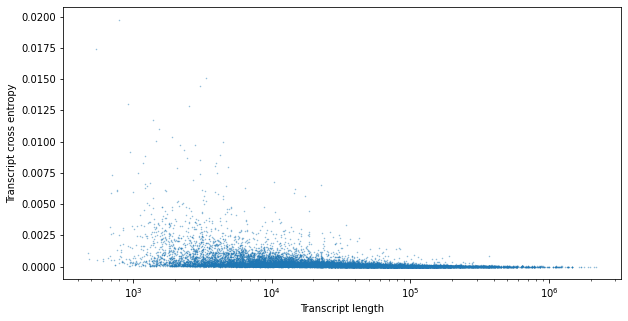

In [80]:
transformerLoss = pd.read_csv(data_dir+'/transformer_40k_training_set_loss_090522.csv',index_col=0)
transformerLoss = transformerLoss.reset_index()
transformerLoss = transformerLoss.rename(columns={'index':'transcript'})
annotation = pd.read_csv(data_dir+'/annotation_ensembl_v87_{}.txt'.format(setType),sep='\t',header=None)[[0,1,2,3,4,5]]
annotation.columns = ['name','chrom','strand','tx_start','tx_end','donors']
annotation['n_junctions'] = annotation['donors'].apply(lambda x: len(x.split(',')))
annotation['transcript'] = annotation['name'].apply(lambda x: x.split('---')[-2].split('.')[0]).values
tmp = annotation.merge(transformerLoss,on='transcript').sort_values('CrossEntropy')
#tmp['gene_start'] = tmp['gene'].apply(lambda x: geneStartEnd[x][0])
#tmp['gene_end'] = tmp['gene'].apply(lambda x: geneStartEnd[x][1])
#plt.scatter(np.log10(np.absolute(tmp['tx_start']-tmp['tx_end'])),tmp['KL'])
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.absolute(tmp['tx_start']-tmp['tx_end']),tmp['CrossEntropy'],s=0.25,alpha=0.5)
#ax.axvline(x=SL, color='k', linestyle='-',alpha=0.8,label='Sequence length (SL)')
#ax.axvline(x=2*SL, color='k', linestyle='--',alpha=0.8,label='2*SL')
#ax.axvline(x=3*SL, color='k', linestyle='-.',alpha=0.8,label='3*SL')
ax.set_xscale('log')
ax.set_xlabel('Transcript length')
plt.ylabel('Transcript cross entropy')
#ax.legend()
fig.set_size_inches(10, 5)
fig.savefig('../Results/Transformer_LossPerTranscript_200522.png', format='png', dpi=400)
plt.show()

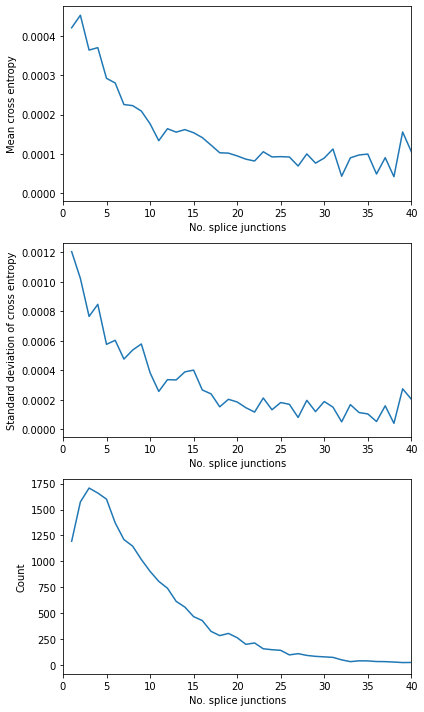

In [82]:
transformerLoss = pd.read_csv(data_dir+'/transformer_40k_training_set_loss_090522.csv',index_col=0)
transformerLoss = transformerLoss.reset_index()
transformerLoss = transformerLoss.rename(columns={'index':'transcript'})
annotation = pd.read_csv(data_dir+'/annotation_ensembl_v87_{}.txt'.format(setType),sep='\t',header=None)[[0,1,2,3,4,5]]
annotation.columns = ['name','chrom','strand','tx_start','tx_end','donors']
annotation['n_junctions'] = annotation['donors'].apply(lambda x: len(x.split(',')))
annotation['transcript'] = annotation['name'].apply(lambda x: x.split('---')[-2].split('.')[0]).values
tmp = annotation.merge(transformerLoss,on='transcript').sort_values('CrossEntropy')
#tmp['gene_start'] = tmp['gene'].apply(lambda x: geneStartEnd[x][0])
#tmp['gene_end'] = tmp['gene'].apply(lambda x: geneStartEnd[x][1])
#plt.scatter(np.log10(np.absolute(tmp['tx_start']-tmp['tx_end'])),tmp['KL'])

fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(6,10))
tmp['CrossEntropy/length'] =  tmp['CrossEntropy']/np.absolute(tmp['tx_start']-tmp['tx_end'])
tmp2 = tmp.groupby('n_junctions').mean()
ax1.plot(tmp2.index,tmp2['CrossEntropy'])
#ax.scatter(tmp['n_junctions'],loss,s=0.25,alpha=0.5)
#ax.axvline(x=SL, color='k', linestyle='-',alpha=0.8,label='Sequence length (SL)')
#ax.axvline(x=2*SL, color='k', linestyle='--',alpha=0.8,label='2*SL')
#ax.axvline(x=3*SL, color='k', linestyle='-.',alpha=0.8,label='3*SL')
#ax.set_xscale('log')
ax1.set_xlabel('No. splice junctions')
ax1.set_ylabel('Mean cross entropy')

tmp['CrossEntropy/length'] =  tmp['CrossEntropy']/np.absolute(tmp['tx_start']-tmp['tx_end'])
tmp2 = tmp.groupby('n_junctions').std()
ax2.plot(tmp2.index,tmp2['CrossEntropy'])
#ax.scatter(tmp['n_junctions'],loss,s=0.25,alpha=0.5)
#ax.axvline(x=SL, color='k', linestyle='-',alpha=0.8,label='Sequence length (SL)')
#ax.axvline(x=2*SL, color='k', linestyle='--',alpha=0.8,label='2*SL')
#ax.axvline(x=3*SL, color='k', linestyle='-.',alpha=0.8,label='3*SL')
#ax.set_xscale('log')
ax2.set_xlabel('No. splice junctions')
ax2.set_ylabel('Standard deviation of cross entropy')
#ax.legend()
#fig.savefig('../Results/Transformer_LossPerTranscript_200522.png', format='png', dpi=400)
#plt.show()

tmp2 = tmp.groupby('n_junctions').count()
ax3.plot(tmp2.index,tmp2['CrossEntropy'])
#ax.axvline(x=SL, color='k', linestyle='-',alpha=0.8,label='Sequence length (SL)')
#ax.axvline(x=2*SL, color='k', linestyle='--',alpha=0.8,label='2*SL')
#ax.axvline(x=3*SL, color='k', linestyle='-.',alpha=0.8,label='3*SL')
#ax.set_xscale('log')
ax3.set_xlabel('No. splice junctions')
ax3.set_ylabel('Count')
ax1.set_xlim([0,40])
ax2.set_xlim([0,40])
ax3.set_xlim([0,40])
#ax.legend()
fig.tight_layout()
fig.savefig('../Results/Transformer_LossPerJunction_200522.png', format='png', dpi=400)
plt.show()